In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 0 #June 29nd, 2023

# Load Data

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72


C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching files for DS_16
Fetching files for DS_17
Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.t

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

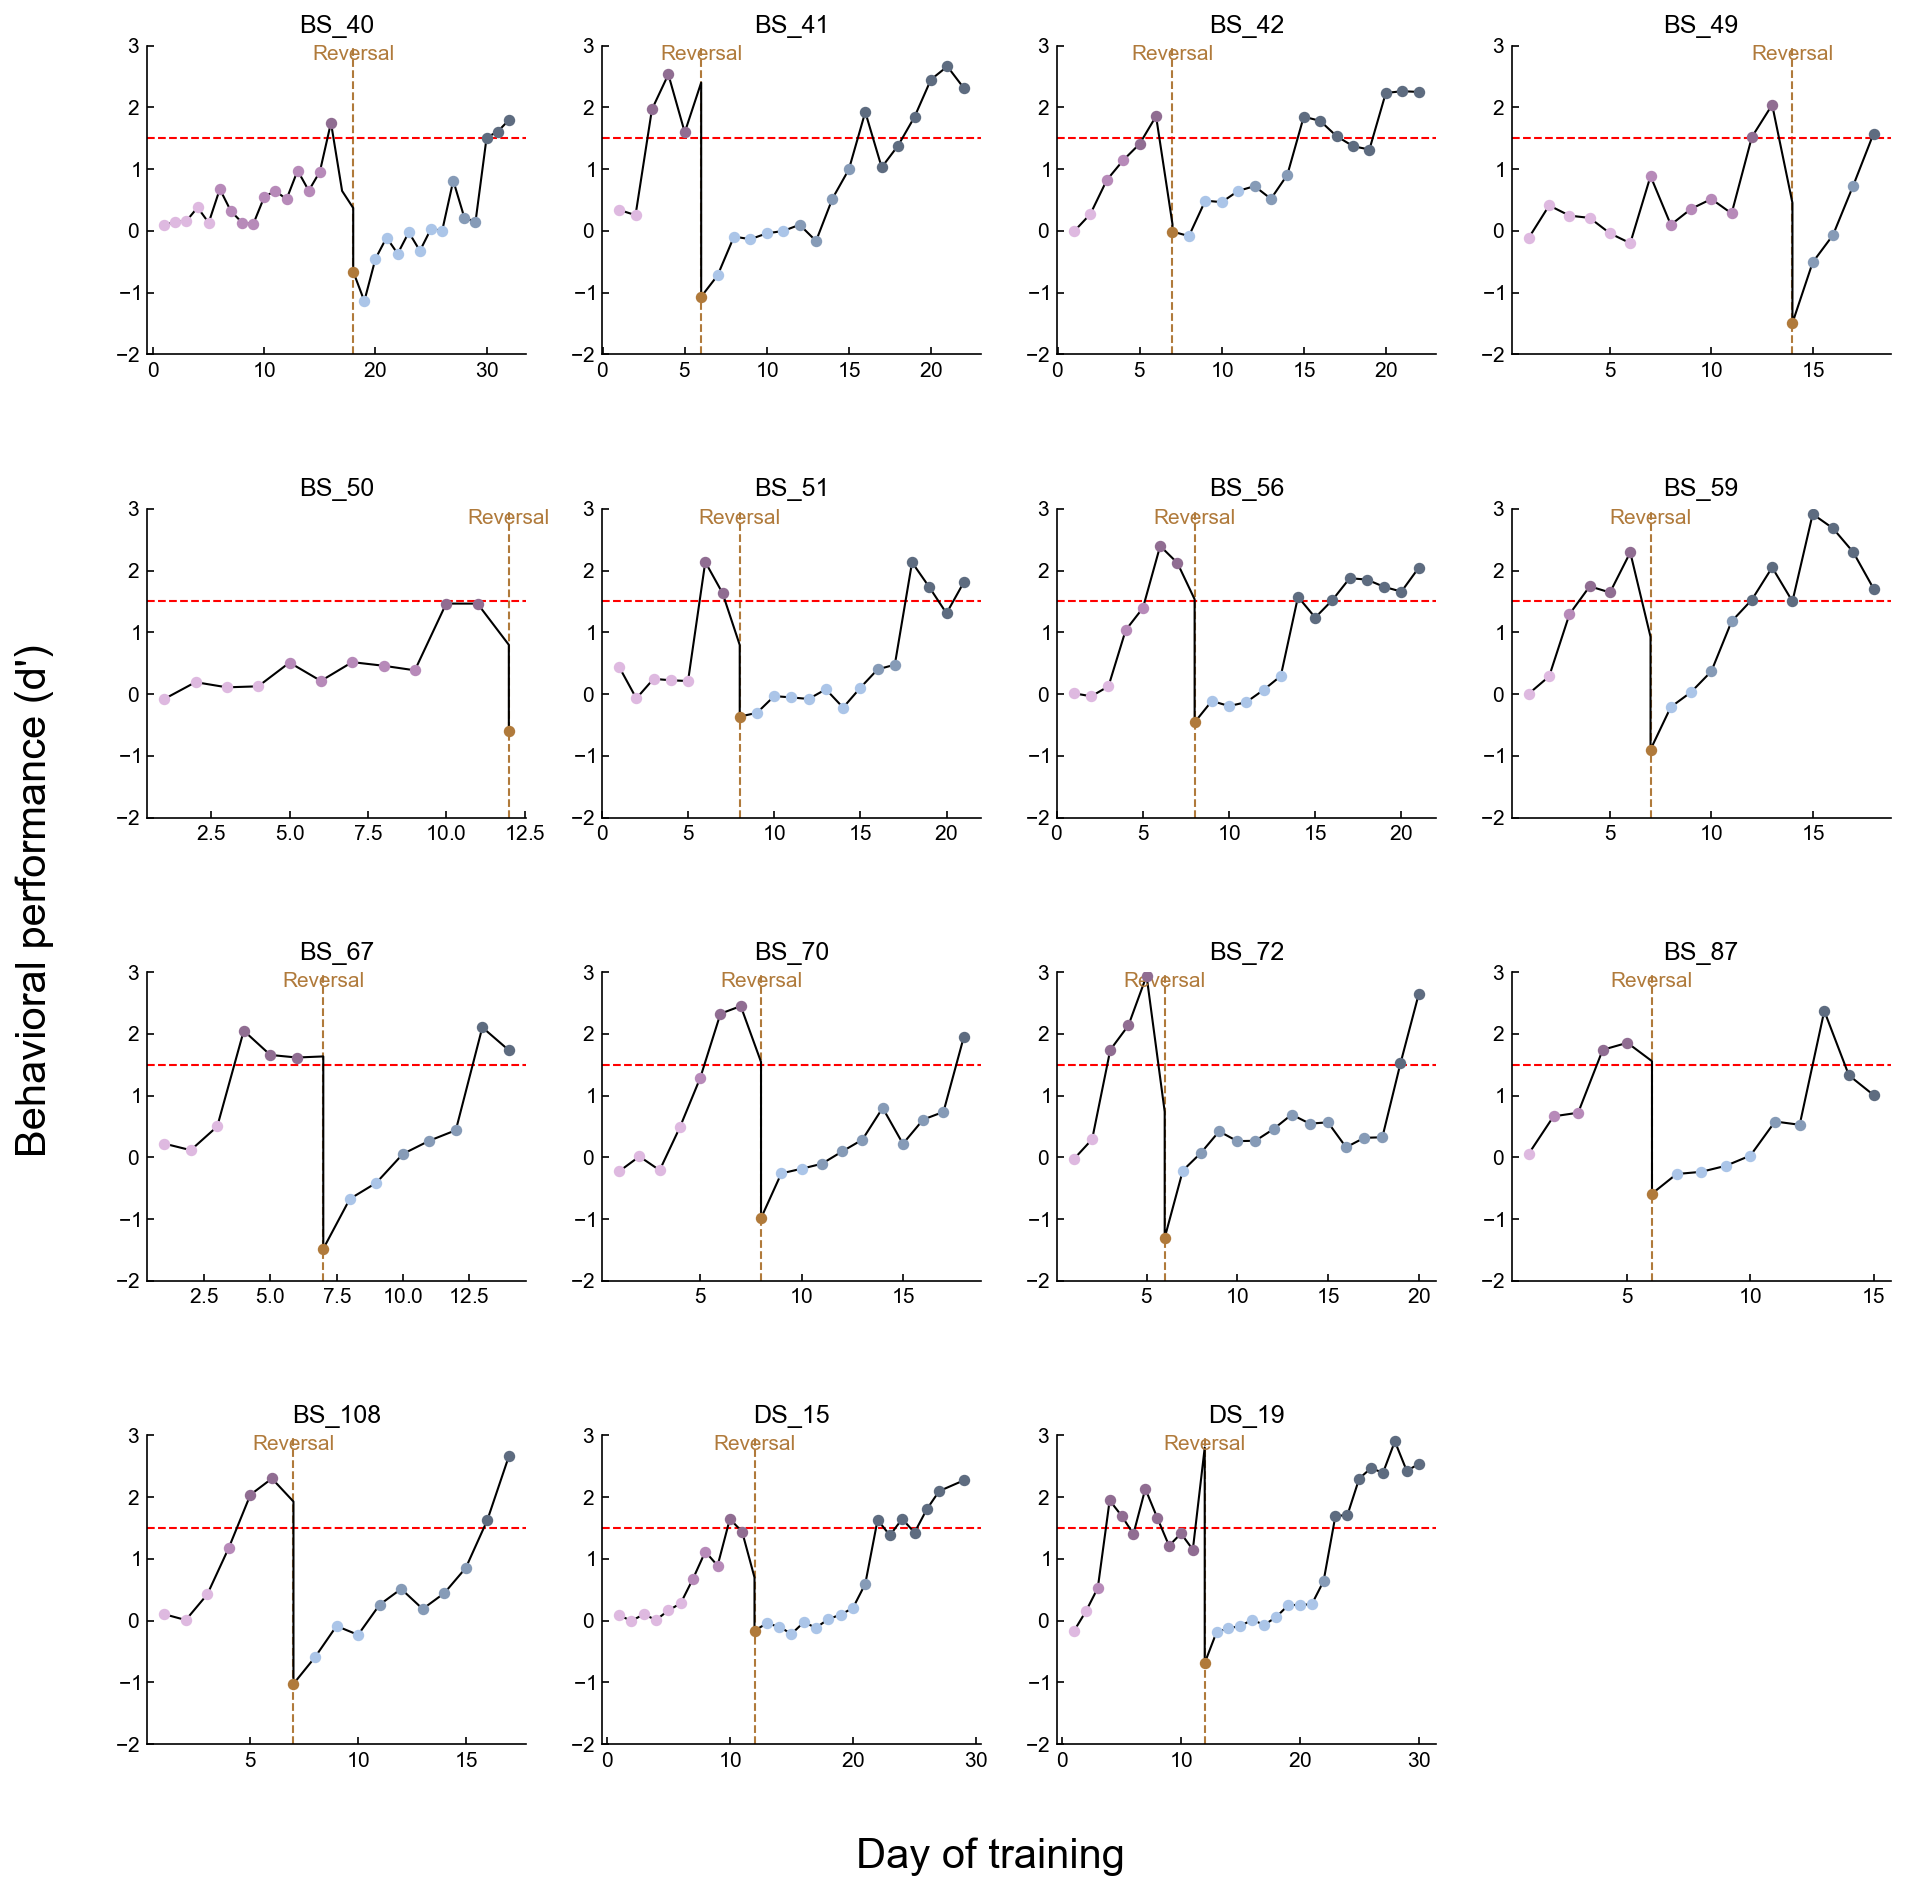

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 723/723 [00:10<00:00, 71.59it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1830/1830 [00:27<00:00, 67.11it/s] 

errors for: []


# Load Decoding Data

In [7]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [8]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1830it [00:06, 274.80it/s]


In [9]:
def get_TE_mask(acc,pval_s,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s,pval_stim_c)
is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s,pval_choice_c)

Task encoder threshold: 0.55951845
Task encoder threshold: 0.593702839530461


In [10]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# RampingNorm_preearly = []
# RampingNorm_prelate = []
# RampingNorm_preexpert = []
# RampingNorm_postearly = []
# RampingNorm_postlate = []
# RampingNorm_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

# cellstouseFR = 'all cells'
cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# RampingNorm_preearly = np.array(RampingNorm_preearly)
# RampingNorm_prelate = np.array(RampingNorm_prelate)
# RampingNorm_preexpert = np.array(RampingNorm_preexpert)
# RampingNorm_postearly = np.array(RampingNorm_postearly)
# RampingNorm_postlate = np.array(RampingNorm_postlate)
# RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1830it [00:27, 66.91it/s] 


In [11]:
FRmod_baseline_median = 3.5
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.mean(np.greater(ilep.rmnan(FRmod_preearly),FRmod_baseline_median))
FRmod_prelate_pc = np.mean(np.greater(ilep.rmnan(FRmod_prelate),FRmod_baseline_median))
FRmod_preexpert_pc = np.mean(np.greater(ilep.rmnan(FRmod_preexpert),FRmod_baseline_median))
FRmod_postearly_pc = np.mean(np.greater(ilep.rmnan(FRmod_postearly),FRmod_baseline_median))
FRmod_postlate_pc = np.mean(np.greater(ilep.rmnan(FRmod_postlate),FRmod_baseline_median))
FRmod_postexpert_pc = np.mean(np.greater(ilep.rmnan(FRmod_postexpert),FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)

baseline: 3.5
0.8108108108108109
0.5294117647058824
0.64
0.6929824561403509
0.4224137931034483
0.48936170212765956


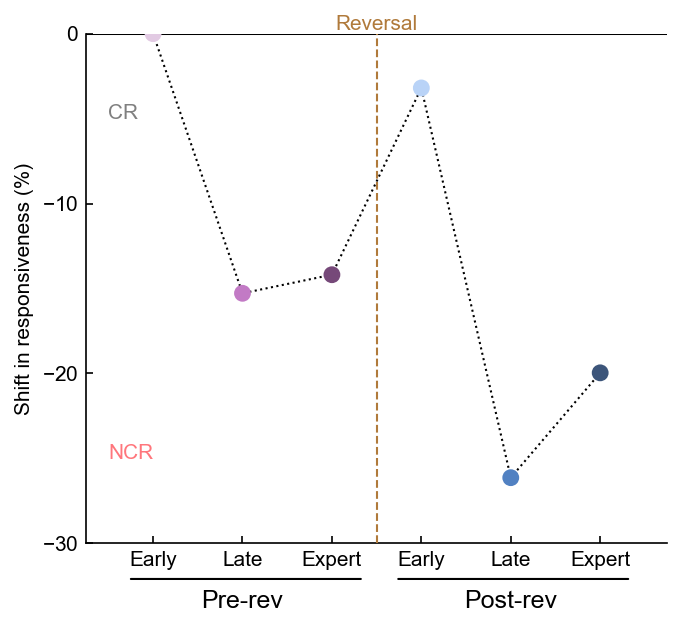

In [25]:
fig, ax = plt.subplots(figsize=(5,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-FRmod_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-FRmod_preearly_pc*100),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)








xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-30,0])
ax.set_yticks([-30,-20,-10,0])
ax.text(-0.5,-5,'CR',color=CR_COLOR)
ax.text(-0.5,-25,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

# ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
# ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
# lgd = ax.legend(frameon=False,loc=(1,0.85))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+1
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.48, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.94, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Stimulus Task Encoder Shift in responsiveness V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

# Ramping

In [26]:
RampingNorm_preearly = []
RampingNorm_prelate = []
RampingNorm_preexpert = []
RampingNorm_postearly = []
RampingNorm_postlate = []
RampingNorm_postexpert = []

#cellstouseFR = 'all cells'
cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
    if rampingMod <= 0:
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre late':
        RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre expert':
        RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post early':
        RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post late':
        RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post expert':
        RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)

RampingNorm_preearly = np.array(RampingNorm_preearly)
RampingNorm_prelate = np.array(RampingNorm_prelate)
RampingNorm_preexpert = np.array(RampingNorm_preexpert)
RampingNorm_postearly = np.array(RampingNorm_postearly)
RampingNorm_postlate = np.array(RampingNorm_postlate)
RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1682it [00:21, 79.98it/s] 


In [28]:
RampingNorm_threshold = 0.5
print('baseline: '+str(RampingNorm_threshold))

#These numbers are essentially %CR
RampingNorm_preearly_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_preearly)),RampingNorm_threshold))
RampingNorm_prelate_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_prelate)),RampingNorm_threshold))
RampingNorm_preexpert_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_preexpert)),RampingNorm_threshold))
RampingNorm_postearly_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postearly)),RampingNorm_threshold))
RampingNorm_postlate_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postlate)),RampingNorm_threshold))
RampingNorm_postexpert_pc = np.nanmean(np.greater(ilep.rmnan(np.abs(RampingNorm_postexpert)),RampingNorm_threshold))
print(RampingNorm_preearly_pc)
print(RampingNorm_prelate_pc)
print(RampingNorm_preexpert_pc)
print(RampingNorm_postearly_pc)
print(RampingNorm_postlate_pc)
print(RampingNorm_postexpert_pc)

baseline: 0.5
0.5
0.5666666666666667
0.5
0.4473684210526316
0.576271186440678
0.48


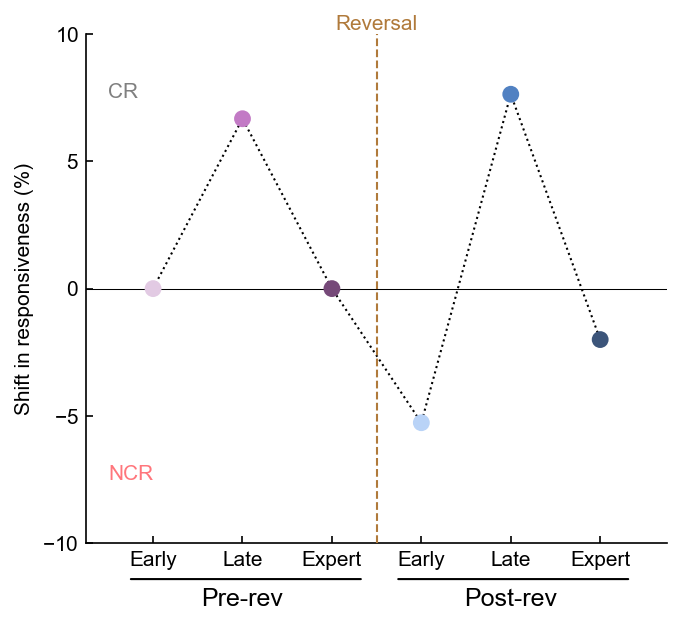

In [35]:
fig, ax = plt.subplots(figsize=(5,4.5))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([RampingNorm_preearly_pc,RampingNorm_prelate_pc,RampingNorm_preexpert_pc,RampingNorm_postearly_pc,RampingNorm_postlate_pc,RampingNorm_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-RampingNorm_preearly_pc*100),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-RampingNorm_preearly_pc*100),c=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)




xlims = [-0.75,numCon-0.25]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-10,10])
ax.set_yticks([-10,-5,0,5,10])
ax.text(-0.5,7.5,'CR',color=CR_COLOR)
ax.text(-0.5,-7.5,'NCR',color=NCR_COLOR)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.75
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.07, -0.07), xycoords='axes fraction', xytext=(0.48, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.94, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','AC Choice Task Encoder Shift in responsiveness V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')